In [1]:
#http://stackoverflow.com/questions/11845055/predicting-from-previous-datevalue-data
import matplotlib.pyplot as plt
import pandas as pd # v. 1.7
import MySQLdb
import numpy as np
import time
import sys
import datetime 
from datetime import datetime
from sympy import *
from sympy.solvers import solve
from sympy.parsing.sympy_parser import parse_expr
from sklearn.metrics import mean_absolute_error,mean_squared_error
import statistics 
%matplotlib inline

import MySQLdb
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

# >>> initial_trend(series, 12)
# -0.7847222222222222

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# # forecast 24 points (i.e. two seasons)
# >>> triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)
# [30, 20.34449316666667, 28.410051892109554, 30.438122252647577, 39.466817731253066, ...


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals
##-----------------------------------------------------------------------------------
from sklearn.metrics import mean_squared_error
def fittingparameter(data_y,j):
    count_alpha = 0
    count_beta = 0
    count_gamma = 0
    alpha = float(0)
    beta = float(0)
    gamma = float(0)
    index_alpha =[]
    index_beta =[]
    index_gamma = []
    act = j
    data = data_y
    pred_no = 96
    ramda = 0.1
    MSE_holtload = []
    query = "SELECT active_power FROM prediction.data15min_4y WHERE Timestamp >= '%s' AND TimeStamp <= '%s';"% (time_b[act+1],time_b[act+96])
#     query = "SELECT active_power FROM prediction.data15min_4y WHERE Timestamp = '%s' ;"% (time_b[act+1])
    print query
    df = pd.read_sql(query, conn)
    while (alpha <= float(1)):
        count_alpha += 1
        beta = float(0)
        while (beta <=float(1)):
            count_beta += 1 
            gamma = float(0)
            while (gamma <= float(1)):
                count_gamma += 1
                pred_h = triple_exponential_smoothing(data, 96*7,alpha,beta ,gamma, pred_no)
                pred_data = pred_h[len(pred_h)-(pred_no):]                                               
                MSE = mean_squared_error (df.active_power, pred_data)   
#                 print MSE              
                MSE_holtload.append(MSE)
                index_alpha.append(alpha)
                index_beta.append(beta)
                index_gamma.append(gamma)     
#                 print index_alpha,index_beta,index_gamma
                gamma += ramda
            beta += ramda
        alpha += ramda  
#     print  count_gamma,count_beta,count_alpha    
    index_MSE = MSE_holtload.index(min(MSE_holtload))
#     print min(MSE_holtload)
#     print index_MSE
    MSE_min = MSE_holtload[index_MSE]
    alpha = index_alpha[index_MSE]
    beta = index_beta[index_MSE]
    gamma= index_gamma[index_MSE]
    print count_alpha,count_beta,count_gamma
    print MSE_min,alpha,beta,gamma
    return (alpha,beta,gamma)


In [2]:
conn = MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()
query = "SELECT Timestamp,active_power FROM prediction.data15min_4y WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-01 00:14:59","2007-03-31 23:59:59")
df = pd.read_sql(query, conn , index_col=['Timestamp'])

pred_no = 1 # power 1 Data/15min in 1Hr --> 60/15 = 4 and 1day = 4*24 = 96
j = 0
i = 0
d = len(df)/96 
day =0

conn = MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()

time_a = pd.date_range('2007-01-01 00:14:59', periods=d*96, freq='15T')
time_b = pd.date_range('2007-01-14 23:59:59', periods=(d*96)+1, freq='15T')

# set databases to empty 
query_empty = """truncate table prediction.pred_totalpower""" 
c.execute(query_empty)

while (j < 96*d ) :    
    if (j%96 == 0):    
        day += 1
        print "DAY:" , day
        query = "SELECT Timestamp,active_power FROM prediction.data15min_4y WHERE Timestamp >= '%s'  AND TimeStamp <= '%s';"% (time_a[0],time_b[j])
        print query
        df = pd.read_sql(query, conn)
        conn.commit()
        data_y = df['active_power'].values.tolist()
        ans_fiting = fittingparameter(data_y,j)
        print "finish process!!! "    
    
    print "data at :" , j,">>>", time_b[j], ans_fiting[0], ans_fiting[1], ans_fiting[2]
    query = "SELECT Timestamp,active_power FROM prediction.data15min_4y WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% (time_a[0],time_b[j])
    df = pd.read_sql(query, conn)
    conn.commit()
    data_y = df['active_power'].values.tolist()   
    pred_h = triple_exponential_smoothing(data_y, 96*7, ans_fiting[0], ans_fiting[1], ans_fiting[2],1)
    pred_data = pred_h[len(pred_h)-(pred_no):]
    c.execute("INSERT INTO prediction.pred_totalpower(Timestamp, watt) VALUES ( %s, %s)",(time_b[j+1],abs(pred_data[0])))
    conn.commit()
    j += 1
print "DONE!!"



DAY: 1
SELECT Timestamp,active_power FROM prediction.data15min_4y WHERE Timestamp >= '2007-01-01 00:14:59'  AND TimeStamp <= '2007-01-14 23:59:59';
SELECT active_power FROM prediction.data15min_4y WHERE Timestamp >= '2007-01-15 00:14:59' AND TimeStamp <= '2007-01-15 23:59:59';
11 121 1331
50557.1880599 0.1 0.2 0.5
finish process!!! 
data at : 0 >>> 2007-01-14 23:59:59 0.1 0.2 0.5
data at : 1 >>> 2007-01-15 00:14:59 0.1 0.2 0.5
data at : 2 >>> 2007-01-15 00:29:59 0.1 0.2 0.5
data at : 3 >>> 2007-01-15 00:44:59 0.1 0.2 0.5
data at : 4 >>> 2007-01-15 00:59:59 0.1 0.2 0.5
data at : 5 >>> 2007-01-15 01:14:59 0.1 0.2 0.5
data at : 6 >>> 2007-01-15 01:29:59 0.1 0.2 0.5
data at : 7 >>> 2007-01-15 01:44:59 0.1 0.2 0.5
data at : 8 >>> 2007-01-15 01:59:59 0.1 0.2 0.5
data at : 9 >>> 2007-01-15 02:14:59 0.1 0.2 0.5
data at : 10 >>> 2007-01-15 02:29:59 0.1 0.2 0.5
data at : 11 >>> 2007-01-15 02:44:59 0.1 0.2 0.5
data at : 12 >>> 2007-01-15 02:59:59 0.1 0.2 0.5
data at : 13 >>> 2007-01-15 03:14:59 0

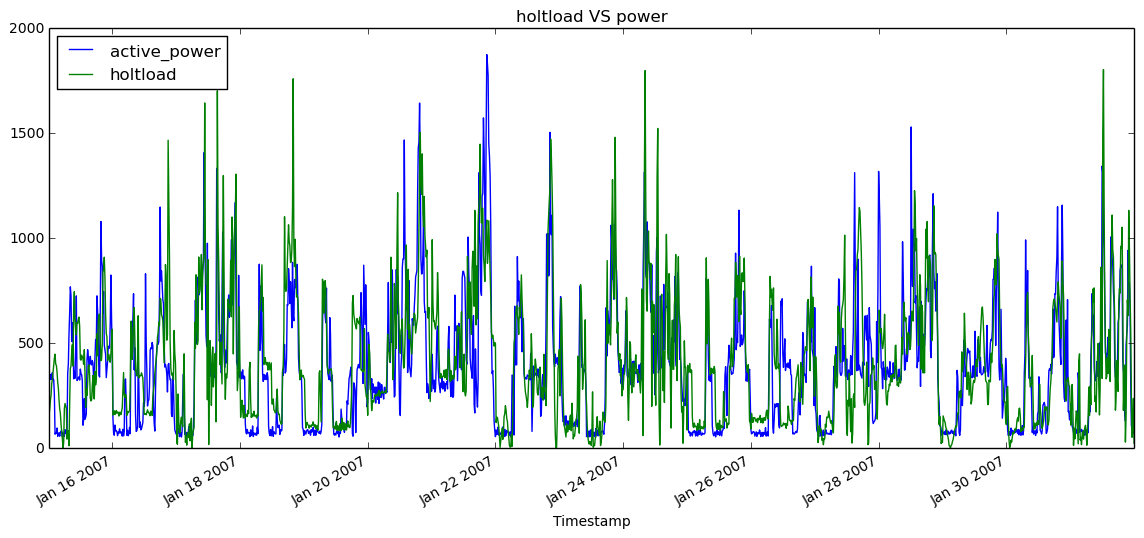

1632 1632
66.6490827405
Size of Data_load:  1632  Day = 17
Size of Data_holr:  1632  Day = 17


In [3]:
conn = MySQLdb.connect("localhost","conn","hems")
cursor = conn.cursor()

# query_holt_sub = "SELECT * FROM prediction.Holtsumsub_15T WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-15 00:00:00","2007-01-16 23:59:59")
query_holt_load = "SELECT * FROM prediction.pred_totalpower WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-15 00:00:00","2007-01-31  23:59:59")
query = "SELECT Timestamp, active_power FROM prediction.data15min_4y WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-15 00:00:00","2007-01-31 23:59:59")
# df_holt_sub = pd.read_sql(query_holt_sub , conn , index_col=['Timestamp'])
df_holt_load = pd.read_sql(query_holt_load, conn , index_col=['Timestamp'])
df = pd.read_sql(query, conn , index_col=['Timestamp'])
# df['holtsub'] = df_holt_sub.watt_sumsub
df['holtload'] = df_holt_load.watt
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title('holtload VS power')
df.plot(ax=ax)
plt.show()
print len(df_holt_load),len(df)


from sklearn.metrics import mean_absolute_error,mean_squared_error
# from sklearn.utils.validation import check_array
df.APE = (np.abs((df.active_power-df_holt_load.watt)/df.active_power))*100
MAPE = np.mean(df.APE)
# df.to_csv('out.csv')

print MAPE
print "Size of Data_load: ", len(df) , " Day =", len(df)/96
print "Size of Data_holr: ", len(df_holt_load) , " Day =", len(df_holt_load)/96